# Usage Examples

This notebook shows off some of what the package can do.

## Setup

First imports and a foundational calculation of cosine-spaced points, which will be reused throughout.

In [1]:
import sys; sys.path.append('../specderiv') # so I can import package code
from specderiv import *
import numpy as np
from matplotlib import pyplot

In [2]:
N = 20
x_n = np.cos(np.linspace(0, N, N+1) * np.pi / N) # length N+1, in keeping with the usage of N in Trefethen.

x = np.linspace(-1, 1, 100) # A denser set of points over the domain, for plotting

## Derivatives in 1D

The most basic thing this package accomplishes is taking derivatives. It's useful to look at what it calculates in 1D against a known answer. Here I'm testing against the function $e^x \sin(5 x)$, which has some interesting wiggles on $[-1, 1]$, is easy to differentiate analytically, and *isn't* periodic.

I've gone all the way up to the $6^{th}$ derivative, because it's beyond what I calculated by hand.

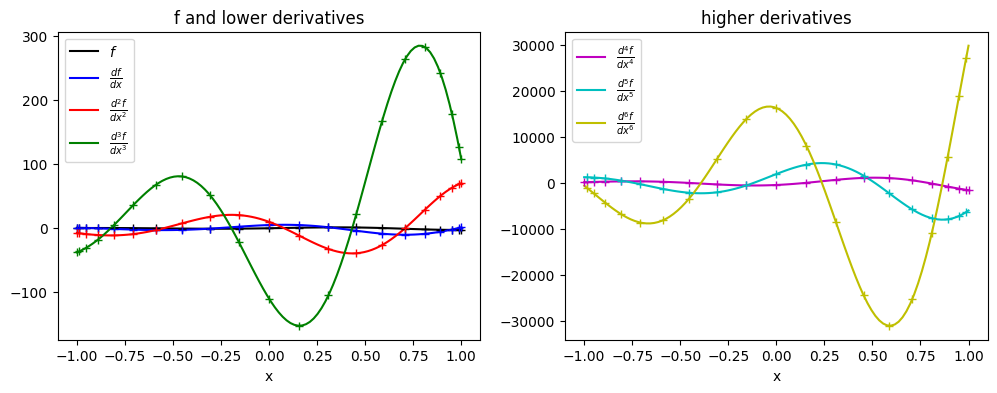

In [3]:
# You can evaluate these with WolframAlpha or by hand.
f = np.exp(x) * np.sin(5*x)
df = 5*np.exp(x) * np.cos(5*x) + f
d2f = 2*np.exp(x) * (5*np.cos(5*x) - 12*np.sin(5*x))
d3f = -2*np.exp(x) * (37*np.sin(5*x) + 55*np.cos(5*x))
d4f = 4*np.exp(x) * (119*np.sin(5*x) - 120*np.cos(5*x))
d5f = 4*np.exp(x) * (719*np.sin(5*x) + 475*np.cos(5*x))
d6f = 8*np.exp(x) * (2035*np.cos(5*x) - 828*np.sin(5*x))

# I'm breaking these apart across two subplots, because the scale gets enormous
# for higher derivatives and obscures what's happening for the lower ones.
fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(x, f, 'k', label="$f$")
axes[0].plot(x, df, 'b', label=r"$\frac{df}{dx}$")
axes[0].plot(x, d2f, 'r', label=r"$\frac{d^2f}{dx^2}$")
axes[0].plot(x, d3f, 'g', label=r"$\frac{d^3f}{dx^3}$")
axes[0].set_title("f and lower derivatives")
axes[0].set_xlabel('x')
axes[0].legend()
axes[1].plot(x, d4f, 'm', label=r"$\frac{d^4f}{dx^4}$")
axes[1].plot(x, d5f, 'c', label=r"$\frac{d^5f}{dx^5}$")
axes[1].plot(x, d6f, 'y', label=r"$\frac{d^6f}{dx^6}$")
axes[1].set_title("higher derivatives")
axes[1].set_xlabel('x')
axes[1].legend()

y = np.exp(x_n) * np.sin(5*x_n)
dy = cheb_deriv(y, 1)
d2y = cheb_deriv(y, 2)
d3y = cheb_deriv(y, 3)
d4y = cheb_deriv(y, 4)
d5y = cheb_deriv(y, 5)
d6y = cheb_deriv(y, 6)

axes[0].plot(x_n, y, 'k+')
axes[0].plot(x_n, dy, 'b+')
axes[0].plot(x_n, d2y, 'r+')
axes[0].plot(x_n, d3y, 'g+')
axes[1].plot(x_n, d4y, 'm+')
axes[1].plot(x_n, d5y, 'c+')
axes[1].plot(x_n, d6y, 'y+');

As you can see, the discrete points are bang on the line, at least at this level of magnification. Let's get a real measure of how close they are using Mean Squared Error.

In [4]:
# Evaluations of the analytic answers at the x_n
f_n = np.exp(x_n) * np.sin(5*x_n)
df_n = 5*np.exp(x_n) * np.cos(5*x_n) + f_n
d2f_n = 2*np.exp(x_n) * (5*np.cos(5*x_n) - 12*np.sin(5*x_n))
d3f_n = -2*np.exp(x_n) * (37*np.sin(5*x_n) + 55*np.cos(5*x_n))
d4f_n = 4*np.exp(x_n) * (119*np.sin(5*x_n) - 120*np.cos(5*x_n))
d5f_n = 4*np.exp(x_n) * (719*np.sin(5*x_n) + 475*np.cos(5*x_n))
d6f_n = 8*np.exp(x_n) * (2035*np.cos(5*x_n) - 828*np.sin(5*x_n))

for i,(truth,computed) in enumerate(zip([f_n, df_n, d2f_n, d3f_n, d4f_n, d5f_n, d6f_n], [y, dy, d2y, d3y, d4y, d5y, d6y])):
    print("%sth derivative MSE:" % i, np.nanmean((truth - computed)**2))

0th derivative MSE: 0.0
1th derivative MSE: 8.947103782078879e-20
2th derivative MSE: 1.9393762681904247e-15
3th derivative MSE: 3.098260792158933e-11
4th derivative MSE: 1.9529787255503098e-07
5th derivative MSE: 0.0001757364499488419
6th derivative MSE: 0.4034986100123082


Notice I've used the `nanmean` function. This is because for derivatives higher than the $4^{th}$ `cheb_deriv` [does not find the endpoints of the derivative](https://github.com/pavelkomarov/spectral-derivatives/issues/1).

The good news is the MSEs are quite low, getting higher for higher derivatives, but remaining very small relative to the scales of the respective functions.

So hooray; it works.

## Derivatives in 2D

Let's work with some higher-dimensional data.

First let's define a function. I'm using $f(x, y) = x^2 \sin(\frac{3\pi}{2} y)$, because it's easy to differentiate analytically, not periodic on $x, y \in [-1, 1]$ (i.e. the function doesn't match up cleanly at opposite bounds), and interesting to look at.

In [5]:
X, Y = np.meshgrid(x, x) # a 100 x 100 grid

F = X**2 * np.sin(3/2*np.pi*Y)

Now let's take some multidimensional derivatives, $\frac{d^2}{dx dy}$ and the Laplacian, $\nabla^2 = \frac{d^2}{dx^2} + \frac{d^2}{dy^2}$.

In [6]:
dxdyF = 3*X*np.pi*np.cos(3/2*np.pi*Y) # d^2 / dx dy
Laplacian = 2*np.sin(3/2*np.pi*Y) - 9/4*np.pi**2 * X**2 * np.sin(3/2*np.pi*Y)

Now let's use `cheb_deriv` to find these same objects. Note we have to resample the function at cosine-spaced points to get started.

In [7]:
X_n, Y_n = np.meshgrid(x_n, x_n) # same shapes as X and Y, but cosine spacing
F_n = X_n**3 * np.sin(3/2*np.pi*Y_n) # F sampled at the cosine-spaced points

### Breaking Multidimensional into 1D Subproblems

Since all the transforms used in `cheb_deriv` are linear, we can accomplish this by looping over all vectors in the data.

In [8]:
dF_n = np.zeros((N+1, N+1))
for i in range(N+1): # iterate first dimension, taking derivatives along second dimension
	dF_n[i] = cheb_deriv(F_n[i], 1)
for j in range(N+1): # iterate second dimension, taking derivatives along the first
	dF_n[:,j] = cheb_deriv(dF_n[:,j], 1)

Laplacian_n = np.zeros((N+1, N+1))
for i in range(N+1): # iterate first dimension, taking derivatives along second dimension
	Laplacian_n[i] += cheb_deriv(F_n[i], 2)
for j in range(N+1): # iterate second dimension, taking derivatives along the first 
	Laplacian_n[:,j] += cheb_deriv(F_n[:,j], 2)

And now plot it all together. The shaded curve is the densely-sampled true function, and the wireframe represents the sparser samples `cheb_deriv` takes and produces.

In [ ]:
def plot_F(): # Put in a function, because I'll have to call this more than once.
    fig = pyplot.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_surface(X, Y, F, cmap='viridis', alpha=0.5)
    ax1.set_title('original function')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_surface(X, Y, dxdyF, cmap='viridis', alpha=0.5)
    ax2.set_title(r'$\frac{d^2}{dxdy}$')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_surface(X, Y, Laplacian, cmap='viridis', alpha=0.5)
    ax3.set_title(r'$\frac{d^2}{dx^2} + \frac{d^2}{dy^2}$')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')

    ax1.plot_wireframe(X_n, Y_n, F_n)
    ax2.plot_wireframe(X_n, Y_n, dF_n)
    ax3.plot_wireframe(X_n, Y_n, Laplacian_n)

    pyplot.tight_layout()

plot_F()

All matches! Great!

### Single Calls per Dimension

Fundamentally, looping over a bunch of 1D vectors has to happen somewhere, but it's more convenient for us and efficient (due to `numpy`'s acceleration, not due to fundamental time complexity) to push that loop downward. [This is actually the best we can do in terms of simplicity and computational cost](https://github.com/pavelkomarov/spectral-derivatives/issues/2).

In [ ]:
dF_n = cheb_deriv(cheb_deriv(F_n, 1, axis=0), 1, axis=1) # One-lineable!
Laplacian_n = cheb_deriv(F_n, 2, axis=0) + cheb_deriv(F_n, 2, axis=1) # One-lineable!

plot_F()

It looks exactly the same as before, which is what we want.

## Simulating a PDE

Now let's do a full on simulation, following [Program 20 in Trefethen](https://epubs.siam.org/doi/epdf/10.1137/1.9780898719598.ch8), except in way fewer lines.

We have:

$$ u_{tt} = u_{xx} + u_{yy} \ , \ -1 \leq x, y \leq 1 \ , \ u = 0 \ \ \text{on the boundary}$$

with initial data

$$ u(x, y, 0) = e^{-40((x - 0.4)^2 + y^2)} \ , \ u_t(x, y, 0) = 0$$

In [ ]:
from scipy.interpolate import griddata
from tqdm.notebook import tqdm

N = 24
x_n = np.cos(np.linspace(0, N, N+1) * np.pi / N)
x_plot = np.arange(-1, 1 + 1/16, 1/16)

X_n, Y_n = np.meshgrid(x_n, x_n) # formerly xx and yy
X_plot, Y_plot = np.meshgrid(x_plot, x_plot)
points = np.stack([X_n.ravel(), Y_n.ravel()], -1) # shape (N, 2) in 2d, needed for griddata()

dt = 6/(N**2) # around the order of dt we want
plotgap = int((1/3)/dt) # plot every third of a second, which is this many dts

u = [np.exp(-40*((X_n - 0.4)**2 + Y_n**2))] # Keep all time slices for animation and leapfrog

fig = pyplot.figure(figsize=(10, 10))
for n in tqdm(range(0, 3*plotgap + 1)):
    t = n*dt
    if n % plotgap == 0: # plots at multiples of t=1/3
        ax = fig.add_subplot(2, 2, n//plotgap + 1, projection='3d')
        u_plot = griddata(points, u[-1].ravel(), (X_plot, Y_plot), method='cubic')
        ax.plot_wireframe(X_plot, Y_plot, u_plot)
        ax.set_zlim((-0.15, 1))
        ax.view_init(elev=20, azim=-135)
        ax.set_title('t = ' + str(t))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    
    rhs = cheb_deriv(u[-1], 2, axis=0) + cheb_deriv(u[-1], 2, axis=1) # righthand side of PDE
    rhs[:,0] = 0; rhs[:,-1] = 0; rhs[0, :] = 0; rhs[-1,:] = 0 # pin the boundary to 0

    if n == 0:
        u.append(u[-1] + (dt**2)*rhs) # on first iteration u_old is meant to be u, so 2u - 1u = 1u
    else:
        u.append(2*u[-1] - u[-2] + (dt**2)*rhs) # leapfrog update

Interestingly, since `cheb_deriv` is capable of calculating the value of the second derivative on the boundary, I initially did not pin the boundary to 0. However, this causes a blowup, beginning at the edges, which ruins the simulation. I tried making `dt` $\propto \frac{1}{N^4}$, but no dice. I'm not enough of a PDEs wizard yet to understand why this happens despite the 2D derivative being evidently correct.

### Saving as an Animation

To help diagnose exactly when and where the blowup originates, or to just see the simulation in its full glory, it's cool to render all plots as a video. To do this in `matplotlib` you have to use the `FuncAnimation` class, which I find a bit odd (Just let me append frames to a list and save from there.) but workable. 

In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

stage, ax = pyplot.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.view_init(elev=20, azim=-135)
def draw(n):
    u_plot = griddata(points, u[n].ravel(), (X_plot, Y_plot), method='cubic')
    ax.cla() # clear before next plot
    ax.set_title(f't = {n*dt:.3f}')
    ax.set_zlim((-0.15, 1))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.plot_wireframe(X_plot, Y_plot, u_plot)

animator = FuncAnimation(stage, draw, tqdm(range(len(u)))) # https://github.com/matplotlib/matplotlib/issues/29384
pyplot.close()
animator.save('wave.mp4', writer=FFMpegWriter(fps=10))

Now let's see it!

In [ ]:
from IPython.display import Video
Video("wave.mp4", embed=True)

If you're viewing this on GitHub, I didn't upload the video, so you'll have to run locally to see it. You'll need `ffmpeg` installed.